In [1]:
### Notebook for scraping college football data from sports-reference.com

# Dependencies
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

import time
import random

import tqdm as tqdm


# URL of page to be scraped
BASE_URL ='https://www.sports-reference.com/cfb/years/'
END_URL = '-schedule.html'

year_list = list(range(2013, 2015))

min_dealy = 3 # site terms stay they kick if request >20 per minute

# https://www.sports-reference.com/cfb/years/1988-schedule.html

In [2]:
## Block for scraping Wikipedia for List of d1 college football teams

# URL of page to be scraped
# https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs

# Extract table from wikipedia page
wiki_url = 'https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs'
wiki_table = pd.read_html(wiki_url)[0]

wiki_table.head()

# ## save list of teams to csv
# wiki_table.to_csv('TEMP/cfb_d1_teams.csv', index=False)

,School,Nickname,City,State [2],Enrollment,CurrentConference,FormerConferences,FirstYear,JoinedFBS
0,Air Force,Falcons,USAF AcademyColorado Springs[n 1],CO,4181,Mountain West,WAC,1955,1957
1,Akron,Zips,Akron,OH,14516,MAC,"OAC, MCC, OVC",1891,1987
2,Alabama,Crimson Tide,Tuscaloosa,AL,38316,SEC,"SIAA, SoCon",1892,NaN
3,Appalachian State,Mountaineers,Boone,NC,20641,Sun Belt,"NSC, SoCon",1928,2014[n 2]
4,Arizona,Wildcats,Tucson,AZ,49471,Pac-12[n 3],"BIAA, WAC",1899,NaN


In [3]:
import time
def scrape_year_data(year):
    """Scrape game data for a given year from sports-reference.com."""
    # Construct URL for the given year
    url = BASE_URL + str(year) + END_URL
    
    # Try reading the table into a pandas DataFrame
    try:
        df = pd.read_html(url)
        df = pd.DataFrame(df[0])  # Convert response from list to dataframe
    except:
        return None  # Return None if scraping fails
    
    # Clean the dataframe of rows that are not games
    df = df[df['Wk'] != 'Wk']
    
    # Add a 'Year' column to the dataframe to keep track of the year
    df['Season'] = year
    
    return df

# This is the finalized scraping function.


def scrape_all_years(start_year, end_year):
    """Scrape game data for all years in the given range."""
    
    # Initialize an empty master dataframe
    master_df = pd.DataFrame()
    
    for year in range(start_year, end_year + 1):
        # Scrape data for the current year
        year_data = scrape_year_data(year)
        
        if year_data is not None:
            # Append the data to the master dataframe
            master_df = master_df.append(year_data, ignore_index=True)
        
        # Save to CSV every 10 years as a backup
        if year % 10 == 0:
            master_df.to_csv(f"../TEMP/data_backup_{year}.csv", index=False)
        
        # Sleep for 3 seconds to respect rate limits
        time.sleep(3.5)
    
    # Save the entire data at the end
    master_df.to_csv("../data/cfb_scrape_raw.csv", index=False)
    
    return master_df

# The function is ready to be used. You can call it with the desired year range when running it on your machine.


In [4]:
# data = scrape_all_years(1869, 2022)

In [5]:
## Load data from completed scrape
data = pd.read_csv('../data/cfb_scrape_raw.csv')

C:\Users\Justin\AppData\Local\Temp\ipykernel_14808\2456455489.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/cfb_scrape_raw.csv')


In [6]:
### Extract the ranking from the team name where applicable
## Pool ranking is contained in parentheses at the beginning of the team name string of the Winner and Loser columns
def extract_ranking(team_name):
    """Extract the ranking from the team name where applicable."""
    # If the team name does not start with a parenthesis, there is no ranking
    if team_name[0] != '(':
        return None
    
    # Find the closing parenthesis
    closing_paren = team_name.find(')')
    
    # Extract the ranking
    ranking = team_name[1:closing_paren]
    
    return ranking

# Apply function to Winner column and save in new 'Winner_Rank' column
data['Winner_Rank'] = data['Winner'].apply(extract_ranking)
# Apply function to Loser column and save in new 'Loser_Rank' column
data['Loser_Rank'] = data['Loser'].apply(extract_ranking)

# Remove the ranking from the team name but only if it is at the begining of the string
data['Winner'] = data['Winner'].str.replace(r"^\(.*\)","")
data['Loser'] = data['Loser'].str.replace(r"^\(.*\)","")
# data['Winner'] = data['Winner'].str.replace(r"\(.*\)","")
# data['Loser'] = data['Loser'].str.replace(r"\(.*\)","")

# Strip leading and trailing whitespace from team names
data['Winner'] = data['Winner'].str.strip()
data['Loser'] = data['Loser'].str.strip()

# rename columns for clarity
replace_dict = {'RK':'season_index', 'Pts':'Winner_Pts', 'Pts.1':'Loser_Pts', 'Unnamed: 6':'loc_ind', 'Unnamed: 7':'loc_ind2'}

# rename columns
data.rename(columns=replace_dict, inplace=True)

# name column names lower case for consistency
data.columns = data.columns.str.lower()

# Combine the two columns that are location indicators into a single column
# The columns don't overlapp at all so they can be combined into one column
data['loc_ind'] = data['loc_ind'].fillna(data['loc_ind2'])
# drop the loc_ind2 column
data.drop(columns='loc_ind2', inplace=True)

data.info()


C:\Users\Justin\AppData\Local\Temp\ipykernel_14808\790123409.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Winner'] = data['Winner'].str.replace(r"^\(.*\)","")
C:\Users\Justin\AppData\Local\Temp\ipykernel_14808\790123409.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Loser'] = data['Loser'].str.replace(r"^\(.*\)","")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81606 entries, 0 to 81605
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rk           81606 non-null  int64  
 1   wk           81606 non-null  int64  
 2   date         81606 non-null  object 
 3   day          81606 non-null  object 
 4   winner       81606 non-null  object 
 5   winner_pts   81604 non-null  float64
 6   loc_ind      33643 non-null  object 
 7   loser        81606 non-null  object 
 8   loser_pts    81604 non-null  float64
 9   notes        5177 non-null   object 
 10  season       81606 non-null  int64  
 11  time         7354 non-null   object 
 12  winner_rank  14874 non-null  object 
 13  loser_rank   5892 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 8.7+ MB


In [7]:
# save temp csv file to check data
data.to_csv('../TEMP/cfb_scrape_clean.csv', index=False)
data.columns

Index(['rk', 'wk', 'date', 'day', 'winner', 'winner_pts', 'loc_ind', 'loser',
       'loser_pts', 'notes', 'season', 'time', 'winner_rank', 'loser_rank'],
      dtype='object')

In [8]:
#### Data tranformation to classify home away and neutral site games and segment them out / pivot them 
df = data.copy()
# Initialize new columns
df['HostTeamName'] = None
df['HostScore'] = None
df['HostRank'] = None
df['AwayTeamName'] = None
df['AwayScore'] = None
df['AwayRank'] = None
df['NeutralTeam1'] = None
df['NeutralScore1'] = None
df['NeutralRank1'] = None
df['NeutralTeam2'] = None
df['NeutralScore2'] = None
df['NeutralRank2'] = None

# Determine host and away teams based on loc_ind and notes columns
for index, row in df.iterrows():
    if row['loc_ind'] == '@':
        df.at[index, 'HostTeamName'] = row['loser']
        df.at[index, 'HostScore'] = row['loser_pts']
        df.at[index, 'HostRank'] = row['loser_rank']
        df.at[index, 'AwayTeamName'] = row['winner']
        df.at[index, 'AwayScore'] = row['winner_pts']
        df.at[index, 'AwayRank'] = row['winner_rank']
    elif pd.isna(row['loc_ind']) or row['loc_ind'] == 'N':
        if row['loc_ind'] == 'N':
            df.at[index, 'NeutralTeam1'] = row['winner']
            df.at[index, 'NeutralScore1'] = row['winner_pts']
            df.at[index, 'NeutralRank1'] = row['winner_rank']
            df.at[index, 'NeutralTeam2'] = row['loser']
            df.at[index, 'NeutralScore2'] = row['loser_pts']
            df.at[index, 'NeutralRank2'] = row['loser_rank']
        else:
            df.at[index, 'HostTeamName'] = row['winner']
            df.at[index, 'HostScore'] = row['winner_pts']
            df.at[index, 'HostRank'] = row['winner_rank']
            df.at[index, 'AwayTeamName'] = row['loser']
            df.at[index, 'AwayScore'] = row['loser_pts']
            df.at[index, 'AwayRank'] = row['loser_rank']




In [9]:
# Assign Results (Win, Lose, Tie) to each game

# Function to determine result based on score comparison
def determine_result(score1, score2):
    if score1 > score2:
        return 'W'
    elif score1 < score2:
        return 'L'
    else:
        return 'T'

# Calculate results for host, away, and neutral teams
df['HostTeamResult'] = df.apply(lambda row: determine_result(row['HostScore'], row['AwayScore']) if pd.notna(row['HostScore']) and pd.notna(row['AwayScore']) else None, axis=1)
df['AwayTeamResult'] = df.apply(lambda row: determine_result(row['AwayScore'], row['HostScore']) if pd.notna(row['HostScore']) and pd.notna(row['AwayScore']) else None, axis=1)
df['NeutralTeam1Result'] = df.apply(lambda row: determine_result(row['NeutralScore1'], row['NeutralScore2']) if pd.notna(row['NeutralScore1']) and pd.notna(row['NeutralScore2']) else None, axis=1)
df['NeutralTeam2Result'] = df.apply(lambda row: determine_result(row['NeutralScore2'], row['NeutralScore1']) if pd.notna(row['NeutralScore1']) and pd.notna(row['NeutralScore2']) else None, axis=1)

# # Display the transformed dataframe with results and notes column
# df[['date', 'HostTeamName', 'HostScore', 'HostRank', 'HostTeamResult', 'AwayTeamName', 'AwayScore', 'AwayRank', 'AwayTeamResult',
#     'NeutralTeam1', 'NeutralScore1', 'NeutralRank1', 'NeutralTeam1Result', 'NeutralTeam2', 'NeutralScore2', 'NeutralRank2', 'NeutralTeam2Result', 'notes']].head()


In [10]:

# # Show the transformed dataframe
# df[['season','date', 'HostTeamName', 'HostTeamResult', 'HostScore', 'HostRank', 'AwayTeamName', 'AwayTeamResult', 'AwayScore', 'AwayRank',
#     'NeutralTeam1', 'NeutralTeam1Result', 'NeutralScore1', 'NeutralRank1', 'NeutralTeam2', 'NeutralTeam2Result', 'NeutralScore2', 'NeutralRank2','notes']].sample(20)

In [11]:
## Save transformed data to csv in data folder
# df.to_csv('../data/cfb_scrape_transformed.csv', index=False)

In [12]:
## Add conference affiliation to teams
import ast # for literal_eval function

conference_df = pd.read_csv('../data/yearly_conference_members.csv')

# rename Unnamed: 0 to year in conference_df
conference_df = conference_df.rename(columns={'Unnamed: 0': 'Year'})

# Convert string representations of lists back into actual lists
for col in conference_df.columns[1:]:
    conference_df[col] = conference_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# Function to retrieve the conference based on year and team name
def get_conference(year, team_name, conference_lookup):
    """
    Given a year and team name, retrieve the conference the team belongs to.
    If no conference found, return "Independent/Unknown".
    """
    return conference_lookup.get((year, team_name), "Independent/Unknown")

# Create a lookup dictionary for team-year to conference mapping
conference_lookup = {}

for _, row in conference_df.iterrows():
    year = row['Year']
    for col, teams in row[1:].items():
        for team in teams:
            conference_lookup[(year, team)] = col

# Use funtion to assign conference affiliation the teams in each row but only if 
# the team name is not null
df['winner_conference'] = df.apply(lambda row: get_conference(row['season'], row['winner'], conference_lookup) if pd.notna(row['winner']) else None, axis=1)
df['loser_conference'] = df.apply(lambda row: get_conference(row['season'], row['loser'], conference_lookup) if pd.notna(row['loser']) else None, axis=1)
df['host_conference'] = df.apply(lambda row: get_conference(row['season'], row['HostTeamName'], conference_lookup) if pd.notna(row['HostTeamName']) else None, axis=1)
df['away_conference'] = df.apply(lambda row: get_conference(row['season'], row['AwayTeamName'], conference_lookup) if pd.notna(row['AwayTeamName']) else None, axis=1)
df['neutral1_conference'] = df.apply(lambda row: get_conference(row['season'], row['NeutralTeam1'], conference_lookup) if pd.notna(row['NeutralTeam1']) else None, axis=1)
df['neutral2_conference'] = df.apply(lambda row: get_conference(row['season'], row['NeutralTeam2'], conference_lookup) if pd.notna(row['NeutralTeam2']) else None, axis=1)


In [13]:
### Create a new column for conference and non-conference games
# Function to determine if a game is a conference game
def determine_conference_game(conference1, conference2):
    if conference1 == conference2:
        return 'Conference'
    else:
        return 'Non-Conference'
    
# Apply to create new 'game_type' column using the determine_conference_game function and the winner and loser conference columns
df['game_type'] = df.apply(lambda row: determine_conference_game(row['winner_conference'], row['loser_conference']) if pd.notna(row['winner_conference']) and pd.notna(row['loser_conference']) else None, axis=1)

# Set game type to Non-Conferecne if either team is Independent/Unknown
df.loc[df['winner_conference'] == 'Independent/Unknown', 'game_type'] = 'Non-Conference'
df.loc[df['loser_conference'] == 'Independent/Unknown', 'game_type'] = 'Non-Conference'

In [14]:
## Use the notes column to determine if a game is a bowl game - if it is save the bowl name to a new column
# Function to determine if a game is a bowl game
def determine_bowl_game(notes):
    if pd.notna(notes) and 'Bowl' in notes:
        return notes, None
    else:
        return None, notes

# Identify games in the National Playoff
def determin_playoff_game(notes):
    if pd.notna(notes) and 'Playoff' in notes:
        return notes, None
    else:
        return None, notes
    
## Is it a conference championship game? - if it is save the note to a new column
# Function to determine if a game is a conference championship game
def determine_championship_game(notes):
    if pd.notna(notes) and 'Championship' in notes:
        return notes, None
    else:
        return None, notes
    

df['bowl'], df['notes'] = zip(*df['notes'].apply(determine_bowl_game))
df['playoff'], df['notes'] = zip(*df['notes'].apply(determin_playoff_game))
df['championship'], df['notes'] = zip(*df['notes'].apply(determine_championship_game))


In [15]:
# df.sample(20)

# value counts of bowl_game column
# df['bowl_game'].value_counts()

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Save the transformed data to a csv file
df.to_csv('../data/cfb_scrape_transformed.csv', index=False)

# Reload the data from the csv file
# df = pd.read_csv('../data/cfb_scrape_transformed.csv')

c:\Users\Justin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


C:\Users\Justin\AppData\Local\Temp\ipykernel_14808\1714201822.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfb_data_filtered['point_differential'] = cfb_data_filtered['winner_pts'] - cfb_data_filtered['loser_pts']
C:\Users\Justin\AppData\Local\Temp\ipykernel_14808\1714201822.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfb_data_filtered['host_conference'] = cfb_data_filtered['host_conference'].map(conference_abbreviations).fillna(cfb_data_filtered['host_conference'])
C:\Users\Justin\AppData\

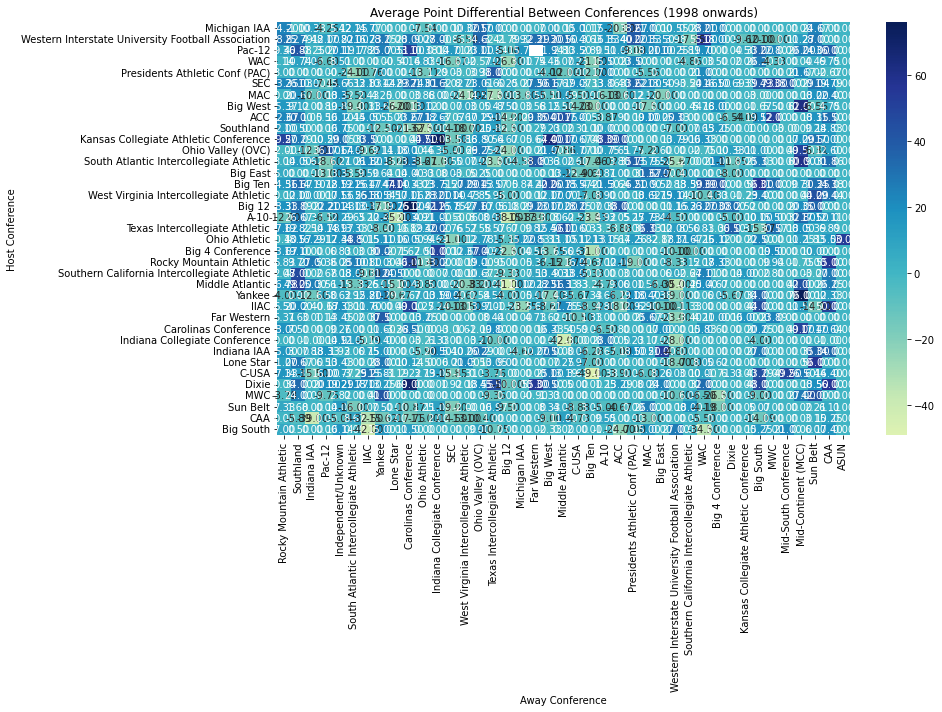

In [17]:


# Load the CSV file
cfb_data = df

# Extract year from the 'date' column
cfb_data['year'] = pd.to_datetime(cfb_data['date']).dt.year

# Filter out Independent teams and keep only data from 1998 onwards
cfb_data_filtered = cfb_data[(cfb_data['host_conference'] != 'Independent/Unknown') & (cfb_data['year'] >= 1998)]

# Calculate point differential for each game
cfb_data_filtered['point_differential'] = cfb_data_filtered['winner_pts'] - cfb_data_filtered['loser_pts']

# Abbreviate conference names
conference_abbreviations = {
    'American Athletic Conference': 'AAC',
    'Atlantic Coast Conference': 'ACC',
    'Big 12 Conference': 'Big 12',
    'Big Ten Conference': 'Big Ten',
    'Conference USA': 'C-USA',
    'Mid-American Conference': 'MAC',
    'Mountain West Conference': 'MWC',
    'Pac-12 Conference': 'Pac-12',
    'Southeastern Conference': 'SEC',
    'Sun Belt Conference': 'Sun Belt',
    'Big East Conference': 'Big East',
    'Western Athletic Conference': 'WAC',
}
cfb_data_filtered['host_conference'] = cfb_data_filtered['host_conference'].map(conference_abbreviations).fillna(cfb_data_filtered['host_conference'])
cfb_data_filtered['away_conference'] = cfb_data_filtered['away_conference'].map(conference_abbreviations).fillna(cfb_data_filtered['away_conference'])

# Drop rows with NaN in host or away conference names
cfb_data_filtered = cfb_data_filtered.dropna(subset=['host_conference', 'away_conference'])

# Create a matrix to store average point differential between conferences
conf_matrix = pd.DataFrame(0, index=cfb_data_filtered['host_conference'].unique(), 
                           columns=cfb_data_filtered['away_conference'].unique())

# Populate the matrix with average point differentials
for idx, row in cfb_data_filtered.iterrows():
    if row['HostTeamResult'] == 'W':
        conf_matrix.loc[row['host_conference'], row['away_conference']] += row['point_differential']
    else:
        conf_matrix.loc[row['host_conference'], row['away_conference']] -= row['point_differential']

# Convert total point differentials to averages
games_played = cfb_data_filtered.groupby(['host_conference', 'away_conference']).size()
for idx in games_played.index:
    conf_matrix.loc[idx] /= games_played[idx]

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, cmap='YlGnBu', center=0, annot=True, fmt=".2f")
plt.title('Average Point Differential Between Conferences (1998 onwards)')
plt.xlabel('Away Conference')
plt.ylabel('Host Conference')
plt.tight_layout()
plt.show()


C:\Users\Justin\AppData\Local\Temp\ipykernel_14808\53270457.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfb_data_filtered['point_differential'] = cfb_data_filtered['winner_pts'] - cfb_data_filtered['loser_pts']
C:\Users\Justin\AppData\Local\Temp\ipykernel_14808\53270457.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfb_data_filtered.replace({'host_conference': conference_abbreviations, 'away_conference': conference_abbreviations,
C:\Users\Justin\AppData\Local\Temp\ipykernel_14808\53270457.py

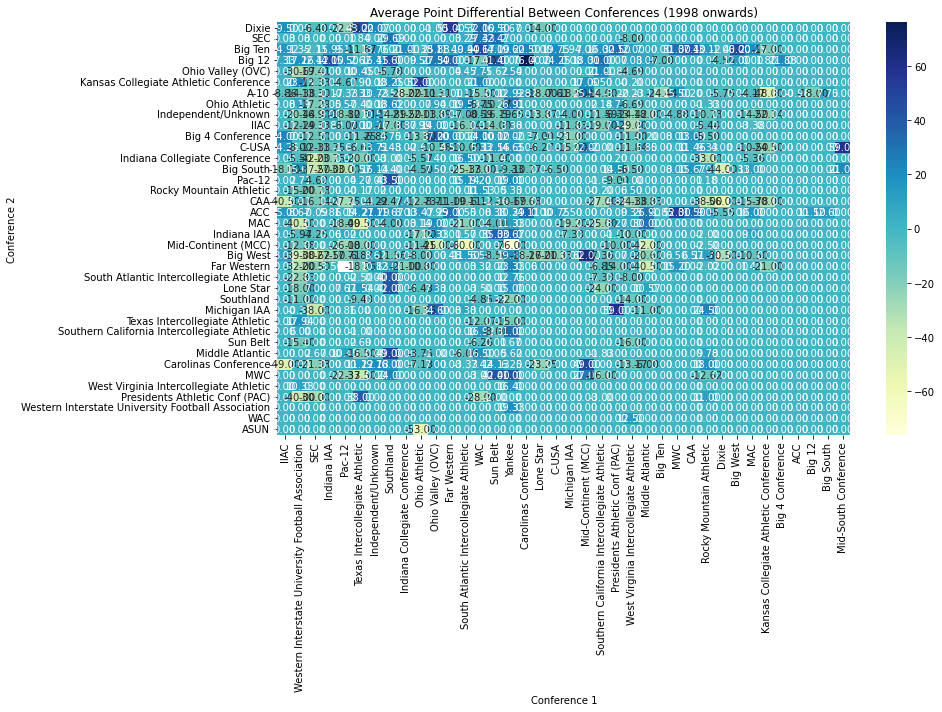

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
cfb_data = df

# Extract year from the 'date' column
cfb_data['year'] = pd.to_datetime(cfb_data['date']).dt.year

# Filter out Independent teams and keep only data from 1998 onwards
cfb_data_filtered = cfb_data[(cfb_data['host_conference'] != 'Independent/Unknown') & (cfb_data['year'] >= 2013)]

# Calculate point differential for each game
cfb_data_filtered['point_differential'] = cfb_data_filtered['winner_pts'] - cfb_data_filtered['loser_pts']

# Abbreviate conference names
conference_abbreviations = {
    'American Athletic Conference': 'AAC',
    'Atlantic Coast Conference': 'ACC',
    'Big 12 Conference': 'Big 12',
    'Big Ten Conference': 'Big Ten',
    'Conference USA': 'C-USA',
    'Mid-American Conference': 'MAC',
    'Mountain West Conference': 'MWC',
    'Pac-12 Conference': 'Pac-12',
    'Southeastern Conference': 'SEC',
    'Sun Belt Conference': 'Sun Belt',
    'Big East Conference': 'Big East',
    'Western Athletic Conference': 'WAC',
}

# Change conference names to abbreviations
cfb_data_filtered.replace({'host_conference': conference_abbreviations, 'away_conference': conference_abbreviations,
                           'winner_conference': conference_abbreviations, 'loser_conference': conference_abbreviations,
                           'neutral1_conference': conference_abbreviations, 'neutral2_conference': conference_abbreviations
                           }, inplace=True)


cfb_data_filtered.replace({'winner_conference': conference_abbreviations, 'loser_conference': conference_abbreviations}, inplace=True)

# Drop rows with NaN in host or away conference names
cfb_data_filtered = cfb_data_filtered.dropna(subset=['winner_conference', 'loser_conference'])

###############################
### NEW CODE FOR PLOTTING #####
# filter to only include non conference games
cfb_data_filtered = cfb_data_filtered[cfb_data_filtered['game_type'] == 'Non-Conference']

################################

# For each game, sort the two conferences alphabetically
cfb_data_filtered['min_conference'] = cfb_data_filtered[['winner_conference', 'loser_conference']].min(axis=1)
cfb_data_filtered['max_conference'] = cfb_data_filtered[['winner_conference', 'loser_conference']].max(axis=1)

# Create a matrix to store average point differential between conferences
conf_matrix = pd.DataFrame(0, index=cfb_data_filtered['min_conference'].unique(), 
                           columns=cfb_data_filtered['max_conference'].unique())

# Populate the matrix with average point differentials
for idx, row in cfb_data_filtered.iterrows():
    if row['winner_conference'] == row['min_conference']:
        conf_matrix.loc[row['min_conference'], row['max_conference']] += row['point_differential']
    else:
        conf_matrix.loc[row['min_conference'], row['max_conference']] -= row['point_differential']

# Convert total point differentials to averages
games_played = cfb_data_filtered.groupby(['min_conference', 'max_conference']).size()
for idx in games_played.index:
    conf_matrix.loc[idx] /= games_played[idx]

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, cmap='YlGnBu', center=0, annot=True, fmt=".2f")
plt.title('Average Point Differential Between Conferences (1998 onwards)')
plt.xlabel('Conference 1')
plt.ylabel('Conference 2')
plt.tight_layout()
plt.show()
